# House Prices Regressions - Minimal code

In [1]:
from __future__ import absolute_import, division, print_function

%matplotlib inline

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras

In [2]:
data_location = '/data/house-prices/house-sales-full.csv'
# data_location = 'https://elephantscale-public.s3.amazonaws.com/data/house-prices/house-sales-full.csv'

house_prices = pd.read_csv(data_location)

input_columns = ['Bedrooms', 'Bathrooms', 'SqFtTotLiving', 'SqFtLot']
label_column = 'SalePrice'
# x = house_prices.loc[:, input_columns]
x = house_prices [input_columns]
y = house_prices[[label_column]]

In [3]:
from sklearn.model_selection import train_test_split

## split train/test = 80% / 20%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

x_train_orig = x_train
x_test_orig = x_test

def my_scaler(df):
    #return (df-df.min())/(df.max()-df.min())  ## this is min/max scaler
    return (df - df.mean()) / df.std()

x_train = my_scaler(x_train_orig)
x_test = my_scaler (x_test_orig)

In [4]:
input_dim = len(x_train.keys())
model = tf.keras.Sequential([
                tf.keras.layers.Dense(units=64, activation=tf.nn.relu, input_shape=[input_dim], name="input_layer"),
                tf.keras.layers.Dense(units=64, activation=tf.nn.relu, name="hidden_1"),
                tf.keras.layers.Dense(units=1, name="output_layer")
            ])

optimizer = tf.keras.optimizers.RMSprop(0.01)

model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 64)                320       
_________________________________________________________________
hidden_1 (Dense)             (None, 64)                4160      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
import datetime
import os

app_name = 'house-prices-regression' # you can change this, if you like

tb_top_level_dir= '/tmp/tensorboard-logs'
tensorboard_logs_dir= os.path.join (tb_top_level_dir, app_name, 
                                    datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S"))
print ("Saving TB logs to : " , tensorboard_logs_dir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_logs_dir, histogram_freq=1)

# The patience parameter is the amount of epochs to check for improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Saving TB logs to :  /tmp/tensorboard-logs/house-prices-regression/2019-09-07--21-59-54


In [6]:
%%time

epochs = 100
print ("training starting ...")
## TODO : to see training output set verbose=2
history = model.fit(
              x_train, y_train,
              epochs=epochs, validation_split = 0.2, verbose=0,
              callbacks=[early_stop, tensorboard_callback])

print ("training done.")

training starting ...
training done.
CPU times: user 1min, sys: 4.22 s, total: 1min 4s
Wall time: 38.4 s


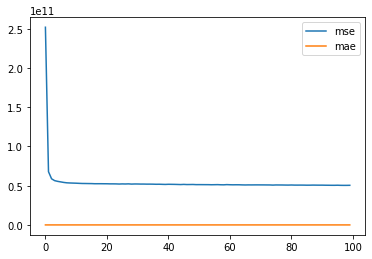

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['mean_squared_error'], label='mse')
plt.plot(history.history['mean_absolute_error'], label='mae')
plt.legend()
plt.show()

In [8]:
metric_names = model.metrics_names
print ("model metrics : " , metric_names)
metrics = model.evaluate(x_test, y_test, verbose=0)

for idx, metric in enumerate(metric_names):
    print ("Metric : {} = {:,.2f}".format (metric_names[idx], metrics[idx]))

model metrics :  ['loss', 'mean_absolute_error', 'mean_squared_error']
Metric : loss = 62,927,823,367.09
Metric : mean_absolute_error = 132,209.62
Metric : mean_squared_error = 62,927,839,232.00


In [9]:
predictions = model.predict(x_test)
predictions_df = pd.DataFrame(x_test_orig)  # use the original one, not scaled
predictions_df['actual_price'] = y_test
predictions_df['predicted_price'] = predictions
predictions_df['error'] = predictions_df['actual_price'] - predictions_df['predicted_price'] 
predictions_df['error_percentage'] = predictions_df['error'].abs() * 100 / predictions_df['actual_price']
benchmark = 5  # 5%
good_predictions = predictions_df[predictions_df['error_percentage'] <= benchmark]

In [10]:
meeting_benchmark = good_predictions.shape[0] *100 / predictions_df.shape[0]

print ("number of predictions within benchmark error ({}%) are  =  {:,}  ({:.1f}% of total)".
       format (benchmark, good_predictions.shape[0], meeting_benchmark))

number of predictions within benchmark error (5%) are  =  727  (13.4% of total)
